# 31. Что такое генеративно-состязательные сети (GAN)

# 32. Делаем генеративно-состязательную сеть в Keras и Tensorflow

In [20]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
from tensorflow import keras
#import keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Lambda

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]

BUFFER_SIZE = x_train.shape[0]
batch_size = 100

BUFFER_SIZE = BUFFER_SIZE // batch_size*batch_size
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

(6200, 28, 28) (6200,)


In [ ]:
#cтандартизация входных данных

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(batch_size)

In [4]:
#формирование сетей

hidden_dim = 2

def dropout_and_batch():
    return Dropout(0.3)(BatchNormalization())

#генератор

generator = tf.keras.Sequential([
    Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
    BatchNormalization(),
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

/home/alexandr/anaconda3/envs/tens/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
#дискриминатор

discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

/home/alexandr/anaconda3/envs/tens/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# формирование сетей
hidden_dim = 2

def dropout_and_batch(x):
  return Dropout(0.3)(BatchNormalization()(x))

input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
  return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

input_dec = Input(shape=(hidden_dim,))
d = Dense(256, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
generator = keras.Model(input_img, decoder(encoder(input_img)), name="generator")

# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

/home/alexandr/anaconda3/envs/tens/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return (loss + kl_loss*0.1)


def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
# обучение
@tf.function
def train_step(images):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(images, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss    

In [24]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (batch_size*MAX_PRINT_LABEL)

  n_epoch = 1
  for epoch in range(epochs):
    print(f'{n_epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if( n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch/n]
    print(': '+str(history[-1]))
    print ('Время эпохи {} в {} секундах'.format(epoch + 1, time.time() - start))
    
    #n_epoch += 1
  return history

1/50: ===========: tf.Tensor(13.144094, shape=(), dtype=float32)
Время эпохи 1 в 1.8517003059387207 секундах
1/50: ===========: tf.Tensor(11.709724, shape=(), dtype=float32)
Время эпохи 2 в 1.843320608139038 секундах
1/50: ===========: tf.Tensor(11.094293, shape=(), dtype=float32)
Время эпохи 3 в 1.847144603729248 секундах
1/50: ===========: tf.Tensor(9.128096, shape=(), dtype=float32)
Время эпохи 4 в 1.8164210319519043 секундах
1/50: ===========: tf.Tensor(9.060643, shape=(), dtype=float32)
Время эпохи 5 в 1.8115177154541016 секундах
1/50: ===========: tf.Tensor(8.533994, shape=(), dtype=float32)
Время эпохи 6 в 1.816591501235962 секундах
1/50: ===========: tf.Tensor(7.3118305, shape=(), dtype=float32)
Время эпохи 7 в 1.8235194683074951 секундах
1/50: ===========: tf.Tensor(6.3419943, shape=(), dtype=float32)
Время эпохи 8 в 1.8138279914855957 секундах
1/50: ===========: tf.Tensor(5.462788, shape=(), dtype=float32)
Время эпохи 9 в 1.8353116512298584 секундах
1/50: ===========: tf.Tens

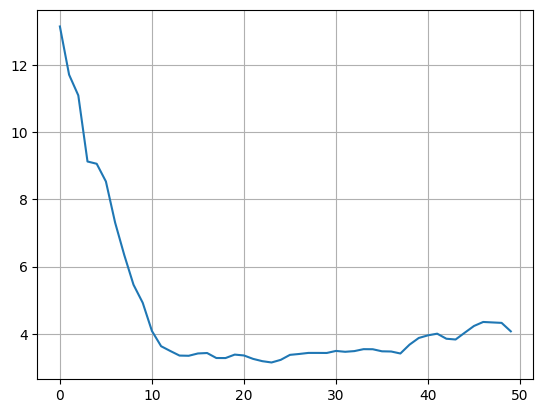

In [30]:
#запуск процесса обучения

EPOCHS = 50
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


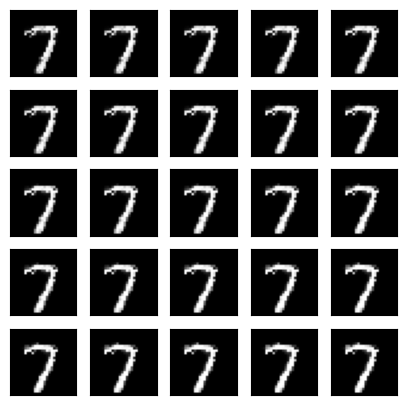

In [31]:
# отображение результатов генерации
n = 2
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = decoder.predict(np.expand_dims([0.5*i/n, 0.5*j/n], axis=0))
    plt.imshow(img.squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)